In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils_notebook import get_logits_targets, modal_probs_decreasing, f_probs_ovr_poe_logits_weighted_generalized

from collections import OrderedDict, Counter
import random
from typing import Dict


/home/metod/miniconda3/envs/msdnet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA = 'cifar100'
LIKELIHOOD = 'softmax'
EPOCH = 149
# MODELS = ['models_repl', 'models_mono_weights', 'models_mono_weights_5', 'models_mono_penal', 'models_mono_penal_stop_grad', 'models_poe_cascade_stop_grad']

# MODELS = ['models_repl', 'models_mono_weights', 'models_mono_weights_5']
# MODELS_NAMES = ['base', 'mono-weights C=1', 'mono-weights C=5']

# MODELS = ['models_repl', 'models_mono_penal', 'models_mono_penal_stop_grad', 'models_mono_penal_3', 'models_mono_penal_5']
# MODELS_NAMES = ['base', 'mono-constr-opt C=1', 'mono-constr-opt C=1 w. stop-grad', 'mono-constr-opt C=3', 'mono-constr-opt C=5']

# MODELS = ['models_repl', 'models_poe_cascade_repl', 'models_poe_cascade_stop_grad']
# MODELS_NAMES = ['base', 'PoE-softmax-cascade', 'PoE-softmax-cascade w. stop-grad']

MODELS = ['models_repl', 'models_mono_penal', 'models_mono_penal_fix']
MODELS_NAMES = ['base', 'mono-constr-opt C=1', 'mono-constr-opt C=1 fix']

logits_dict = {}
for model_name in MODELS:
    _logits, targets, _ = get_logits_targets(DATA, model_name, LIKELIHOOD, EPOCH, cuda=False, logits_type='test')
    logits_dict[model_name] = _logits

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [12]:
# MODEL_FOLDER = 'models_repl'
# LIKELIHOOD = 'softmax'
# EPOCH = 299


# logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, cuda=False)

In [7]:
# PROBS_TYPE = 'BASE'
# PROBS_TYPE = 'PoE'
PROBS_TYPE = 'PoE-OvR'

acc_dict, mono_dict = {}, {}
for model_name in MODELS:
    logits = logits_dict[model_name]

    L = len(logits)
    N = len(targets)

    if PROBS_TYPE == 'PoE':
        logits = logits.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5., 6., 7.])[:, None, None]
        probs = torch.softmax(logits, dim=2)
    elif PROBS_TYPE == 'PoE-OvR':
        T = 1.
        probs = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
    elif PROBS_TYPE == 'BASE':
        probs = torch.softmax(logits, dim=2)

    preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
    acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]

    mono_modal_prob = [round(x, 4) for x in modal_probs_decreasing(preds, probs, layer=L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all").values()]
    mono_y_star = [round(x, 4) for x in modal_probs_decreasing(targets, probs, layer=None, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all").values()]

    print('Model:', model_name)
    print([round(float(x), 4) for x in acc])
    print(mono_modal_prob)
    print(mono_y_star)

    acc_dict[model_name] = acc
    mono_dict[model_name] = modal_probs_decreasing(preds, probs, layer=L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all")

Model: models_repl
[0.5611, 0.6209, 0.6504, 0.6741, 0.6876, 0.6987, 0.6971]
[0.85, 0.34, 0.04, 0.01, 0.0, 0.0, 0.0, 0.0]
[16.4, 12.32, 1.06, 0.02, 0.0, 0.0, 0.0, 0.0]


/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/utils_notebook.py:270: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.repeat(probs.sum(axis=2)[:, :, np.newaxis], C, axis=2)


Model: models_mono_penal
[0.0015, 0.0085, 0.0143, 0.0177, 0.0191, 0.0216, 0.0227]
[43.73, 38.7, 26.22, 18.02, 11.37, 10.02, 8.96, 8.54]
[12.69, 12.55, 10.45, 9.47, 8.73, 8.63, 8.56, 8.5]
Model: models_mono_penal_fix
[0.4992, 0.5695, 0.6165, 0.6402, 0.6538, 0.6659, 0.6811]
[0.57, 0.2, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0]
[15.28, 11.12, 0.79, 0.02, 0.0, 0.0, 0.0, 0.0]


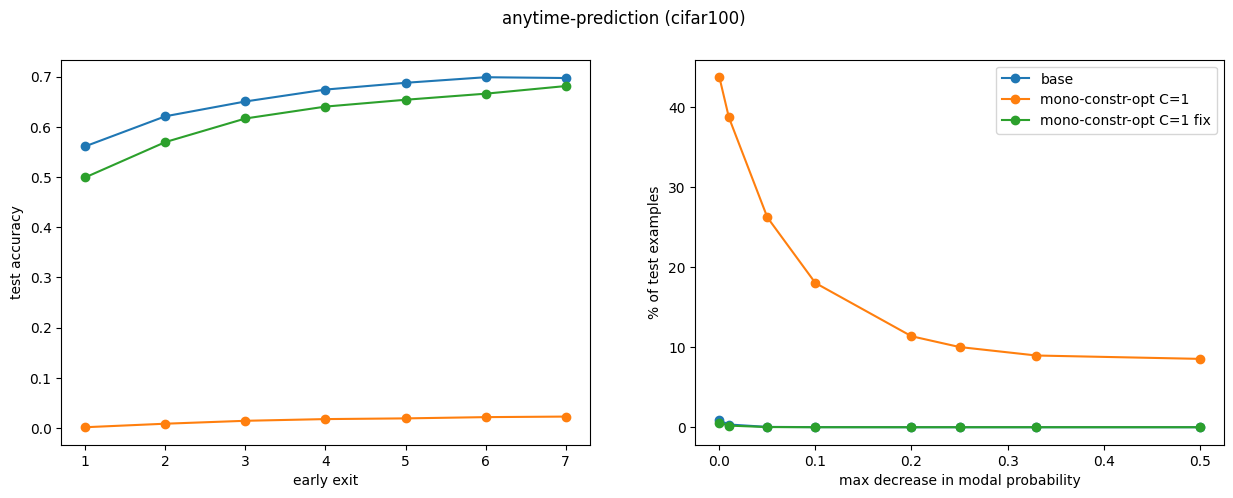

In [8]:
early_exits = [i + 1 for i in range(len(acc))]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for model_name, model_label in zip(MODELS, MODELS_NAMES):
    ax[0].plot(early_exits, acc_dict[model_name], label=model_label, marker='o',)
    ax[1].plot(mono_dict[model_name].keys(), mono_dict[model_name].values(), marker='o', label=model_label)

ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit') 
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples') 
ax[1].legend()

plt.suptitle(f'anytime-prediction ({DATA})')
plt.show()


In [20]:
logits = logits_dict['models_mono_penal_5']
logits = logits.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5., 6., 7.])[:, None, None]
probs = torch.softmax(logits, dim=2)

In [24]:
logits[0, 0, :]

tensor([ 3.9844,  3.6146, -3.1735, -2.3719, -3.7343,  2.4521,  0.9305,  2.2862,
        -1.4497,  4.3440,  3.5849, -2.9722, -4.4427,  2.0083,  3.1740, -2.7255,
         5.0210,  0.9517,  1.9480, -1.4908,  4.6904, -0.0413,  5.1084, -1.4637,
        -1.7045,  2.2657, -1.2187, -3.5985,  2.2179, -1.1642, -7.4309, -2.0956,
        -2.3138, -0.6258, -1.5551, -2.3554,  1.4363,  2.3430, -4.2978,  1.3739,
         0.4642,  2.3706,  0.8303,  0.4528, -2.8489, -2.7730, -4.2866,  2.5145,
        -0.2417, -3.9406,  0.0227,  0.7217,  1.8000,  2.5935,  1.8453, -5.5007,
        -2.8262,  2.7342,  1.3149, -1.0272, -1.5687,  3.3512,  2.9558,  3.3767,
         0.5436,  1.0738,  1.6433, -2.3039, -2.6376, -4.2309,  4.6151, -5.7916,
        -4.8311, -3.9460, -0.9944,  1.3956, -2.6276,  0.7662,  1.1464, -2.1276,
        -0.3354,  3.0420,  0.8762,  4.6509,  1.2516,  0.3808,  3.9723,  1.9342,
         0.5022,  0.2242, -1.4162, -0.5098,  5.7708, -1.9567,  4.0129, -6.3635,
         3.6163, -2.0204, -2.7519, -0.38

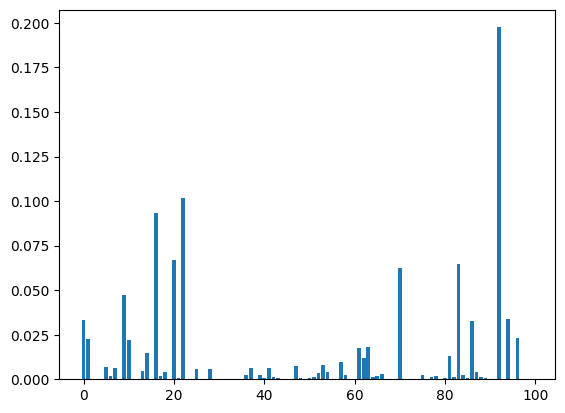

In [23]:
plt.bar([c for c in range(100)], probs[0, 0, :]);